In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import re
plt.rcParams['pdf.use14corefonts'] = True

In [2]:
guardant_table = pd.read_excel('../data/Leshchiner_et_al_Tables.xlsx', sheet_name='SuppTable2_GuardantDatabase')
guardant_drug_table = pd.read_csv('../data/treatment_information_for_classifier.tsv', sep='\t', index_col=0)

In [3]:
# Get list of genes in panel
gene_list = list(pd.unique(guardant_table['gene']))

In [4]:
# List of drugs
drug_index = ['kadcyla', 'tdm-1', 'tykerb', 'nerlynx', 'palbociclib', 'ibrance', 'fulvestrant', 'faslodex', 'ribociclib', 'kisqali', 'tamoxifen',
              'abemiciclib', 'verzenio', 'letrozole', 'femara', 'exemestane', 'aromasin', 'anastrozole', 'arimidex', 'anti-her2']

In [5]:
# Create full event matrix of guardant genomic data

guardant_mut_table = guardant_table.loc[(guardant_table['mut_type'] != 'synonymous') & (guardant_table['mut_type'] != 'amp')
  ].groupby(['patient_id', 'gene']).size().unstack().fillna(0).astype(bool).astype(int)
guardant_amp_table = guardant_table.loc[(guardant_table['mut_type'] == 'amp')
  ].groupby(['patient_id', 'gene']).size().unstack().fillna(0).astype(bool).astype(int)
for gene in gene_list:
    if gene not in guardant_mut_table.columns:
        guardant_mut_table[gene] = 0
    if gene not in guardant_amp_table.columns:
        guardant_amp_table[gene] = 0
guardant_mut_table = guardant_mut_table[gene_list]
guardant_amp_table = guardant_amp_table[gene_list]
guardant_amp_table.columns += '_amp'

full_mat = pd.concat([guardant_mut_table, guardant_amp_table, guardant_drug_table], axis=1).fillna(0)

In [6]:
# Load previously run classifier results

classifier_results = pd.read_excel('../data/Leshchiner_et_al_Tables.xlsx', sheet_name='SuppTable3_Annotated_Subtypes', index_col=0)
classifier_probs = pd.read_csv('../data/classifier_results.tsv', sep='\t', index_col=0)

In [7]:
# Get patients
with open('../data/annotated_tn_patients_GHB_only.txt', 'r') as f:
    annot_tn_patients = f.read().split('\n')

tn_patients = classifier_results.loc[classifier_results['TN_final'] == 'TN'].index

In [8]:
annot_mat = full_mat.loc[annot_tn_patients]

In [9]:
# Create matrix for comut

mut_types = ['synonymous', 'VUS', 'missense', 'indel', 'nonsense', 'splice', 'fusion']

comut_mat = pd.DataFrame(columns=list(tn_patients), index=pd.unique(guardant_table['gene'])).fillna(0)
for p in tn_patients:
    p_df = guardant_table.loc[guardant_table['patient_id'] == p]
    for i, mut_type in enumerate(mut_types):
        type_df = p_df.loc[p_df['mut_type'] == mut_type]
        comut_mat.loc[type_df['gene'], p] = i + 1

In [10]:
# Sort genes and patients

gene_order = [x for x in sorted(comut_mat.index, key=lambda g: sum(comut_mat.loc[g].astype(int).astype(bool)), reverse=True) if (comut_mat.loc[x] >= 1).sum() > 5]
gene_order = gene_order[:30]
comut_mat = comut_mat.loc[gene_order]
patient_order = sorted(list(comut_mat.columns), key=lambda p: list(comut_mat[p].astype(int).astype(bool).values), reverse=True)
comut_mat = comut_mat[patient_order]

annot_comut_mat = comut_mat.loc[gene_order, annot_tn_patients]
predicted_comut_mat = comut_mat.loc[gene_order, list(set(tn_patients) - set(annot_tn_patients))]

In [11]:
# Get prevalences for each mutation type

synonymous_prevalence = (predicted_comut_mat.astype(int) == 1).mean(axis=1)
VUS_prevalence = (predicted_comut_mat.astype(int) == 2).mean(axis=1)
missense_prevalence = (predicted_comut_mat.astype(int) == 3).mean(axis=1)
indel_prevalence = (predicted_comut_mat.astype(int) == 4).mean(axis=1)
nonsense_prevalence = (predicted_comut_mat.astype(int) == 5).mean(axis=1)
splice_prevalence = (predicted_comut_mat.astype(int) == 6).mean(axis=1)
fusion_prevalence = (predicted_comut_mat.astype(int) == 7).mean(axis=1)
# amp_prevalence = (comut_mat.astype(int) == 8).sum(axis=1) / len(comut_mat.columns)
prevalence = (predicted_comut_mat.astype(int) > 0).mean(axis=1)
prevalence_low, prevalence_high =  scipy.stats.beta.interval(.95, (predicted_comut_mat.astype(int) > 0).sum(axis=1).values + 1,
    len(predicted_comut_mat.columns) - (predicted_comut_mat.astype(int) > 0).sum(axis=1).values + 1)
prevalence_error = np.abs(np.array((prevalence_high, prevalence_low)) - prevalence.values)

annot_synonymous_prevalence = (annot_comut_mat.astype(int) == 1).mean(axis=1)
annot_VUS_prevalence = (annot_comut_mat.astype(int) == 2).mean(axis=1)
annot_missense_prevalence = (annot_comut_mat.astype(int) == 3).mean(axis=1)
annot_indel_prevalence = (annot_comut_mat.astype(int) == 4).mean(axis=1)
annot_nonsense_prevalence = (annot_comut_mat.astype(int) == 5).mean(axis=1)
annot_splice_prevalence = (annot_comut_mat.astype(int) == 6).mean(axis=1)
annot_fusion_prevalence = (annot_comut_mat.astype(int) == 7).mean(axis=1)
annot_prevalence = (annot_comut_mat.astype(int) > 0).mean(axis=1)
annot_prevalence_low, annot_prevalence_high = scipy.stats.beta.interval(.95, (annot_comut_mat.astype(int) > 0).sum(axis=1).values + 1,
    len(annot_comut_mat.columns) - (annot_comut_mat.astype(int) > 0).sum(axis=1).values + 1)
annot_prevalence_error = np.abs(np.array((annot_prevalence_high, annot_prevalence_low)) - annot_prevalence.values)

amp_prevalence = full_mat.loc[comut_mat.columns[comut_mat.columns.isin(full_mat.index)], [g + '_amp' for g in gene_order]].mean()
amp_low, amp_high = scipy.stats.beta.interval(.9,
    full_mat.loc[comut_mat.columns[comut_mat.columns.isin(full_mat.index)], [g + '_amp' for g in gene_order]].sum() + 1,
    len(full_mat) - full_mat.loc[comut_mat.columns[comut_mat.columns.isin(full_mat.index)], [g + '_amp' for g in gene_order]].sum() + 1)
amp_prevalence_error = np.abs(np.array((amp_high, amp_low)) - amp_prevalence.values)

annot_amp_prevalence = annot_mat.loc[comut_mat.columns[comut_mat.columns.isin(annot_mat.index)], [g + '_amp' for g in gene_order]].mean()
annot_amp_low, annot_amp_high = scipy.stats.beta.interval(.9,
    annot_mat.loc[comut_mat.columns[comut_mat.columns.isin(annot_mat.index)], [g + '_amp' for g in gene_order]].sum() + 1,
    len(annot_mat) - annot_mat.loc[comut_mat.columns[comut_mat.columns.isin(annot_mat.index)], [g + '_amp' for g in gene_order]].sum() + 1)
annot_amp_prevalence_error = np.abs(np.array((annot_amp_high, annot_amp_low)) - annot_amp_prevalence.values)

In [12]:
# Make tracks for mutation rate and purity

rate_track = pd.Series(index=comut_mat.columns)
for patient in comut_mat.columns:
    if patient.startswith('GHB'):
        rate_track[patient] = ((guardant_table['patient_id'] == patient) & (guardant_table['mut_type'] != 'amp')).sum()
                
purity_track = pd.Series(index=comut_mat.columns)
for patient in comut_mat.columns:
    if patient.startswith('GHB'):
        purity_track[patient] = guardant_table.loc[guardant_table['patient_id'] == patient, 'percentage'].max()

In [13]:
# Make track for probability of classification
non_annot_tn_patients = list(set(tn_patients) - set(annot_tn_patients))

tn_prob = (1 - classifier_probs['p(ER+)']) * (1 - classifier_probs['p(HER2+|ER-)'])
classification_track = tn_prob[non_annot_tn_patients]
for p in annot_tn_patients:
    classification_track[p] = 1.
classification_track = classification_track[patient_order]

/var/folders/ty/nj77bh0j35b1mmnbxssy9xz40000gn/T/ipykernel_38229/3946026630.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_yticklabels([0, 50], fontsize=10)


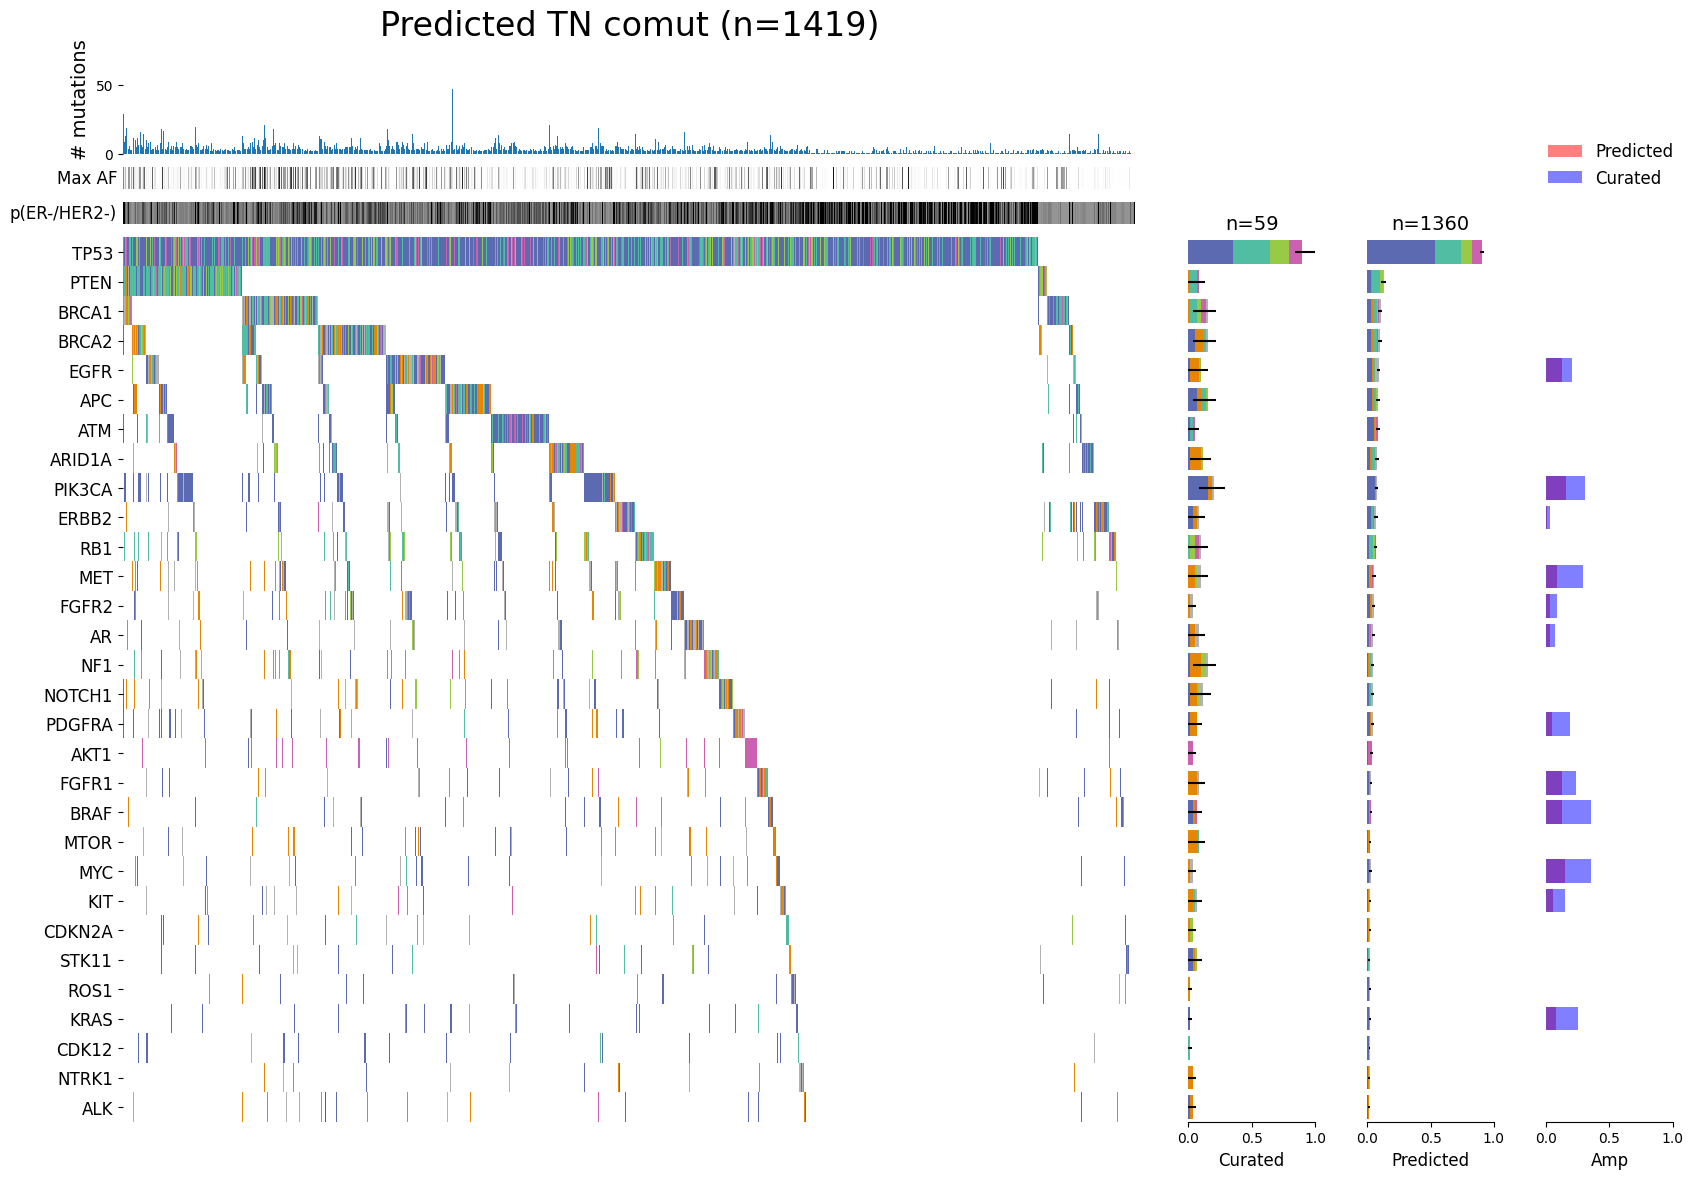

In [14]:
# Plot comut
n_muts = len(gene_order)
fig, axes = plt.subplots(figsize=(20, 14), nrows=4, ncols=4, sharey='row', sharex='col',
                         gridspec_kw={'width_ratios': (8, 1, 1, 1), 'height_ratios': (5, 1, 1, 40), 'wspace': .15, 'hspace': .05})
cmap = matplotlib.colors.ListedColormap(['#FFFFFF', '#B2B2B2', '#E58704', '#5C6AB1', '#51BDA3', '#98CA45', '#CC61B0', '#25796C'])
axes[0, 0].bar(range(len(rate_track)), rate_track)
axes[0, 0].set_ylim(0, 80)
axes[0, 0].set_yticklabels([0, 50], fontsize=10)
axes[0, 0].set_ylabel('# mutations', fontsize=14)
axes[0, 0].set_title('Predicted TN comut (n={})'.format(len(comut_mat.columns)), fontsize=24)

axes[0, 1].remove()
axes[0, 2].remove()
axes[0, 3].remove()

axes[1, 0].matshow(np.expand_dims(purity_track.values, 0) / 100., cmap='Greys', aspect='auto', vmin=0, vmax=1)
axes[1, 0].set_ylabel('Max AF', fontsize=12, rotation='horizontal', x=-.1, y=.5, horizontalalignment='right', verticalalignment='center')
axes[1, 0].set_yticks([])
axes[1, 0].set_ylim(.5, -.5)

axes[1, 1].remove()
axes[1, 2].remove()
axes[1, 3].remove()

axes[2, 0].matshow(np.expand_dims(classification_track, 0), cmap='Greys', aspect='auto', vmin=0, vmax=1)
axes[2, 0].set_ylabel('p(ER-/HER2-)', fontsize=12, rotation='horizontal', x=-.1, y=.5, horizontalalignment='right', verticalalignment='center')
axes[2, 0].set_yticks([])
axes[2, 0].set_ylim(.5, -.5)

axes[2, 1].remove()
axes[2, 2].remove()
axes[2, 3].remove()

axes[3, 0].matshow(comut_mat.astype(int), aspect='auto', cmap=cmap, vmin=0, vmax=7)
axes[3, 0].set_ylim(n_muts - .5, -.5)
axes[3, 0].set_xticks([])
axes[3, 0].set_xlim(-1, len(comut_mat.columns) + 1)
axes[3, 0].set_yticks(range(n_muts))
axes[3, 0].set_yticklabels(gene_order, fontsize=12)

axes[3, 1].barh(np.arange(n_muts), annot_missense_prevalence, color='#5C6AB1')
axes[3, 1].barh(np.arange(n_muts), annot_VUS_prevalence, left=annot_missense_prevalence, color='#E58704')
axes[3, 1].barh(np.arange(n_muts), annot_indel_prevalence, left=annot_missense_prevalence + annot_VUS_prevalence, color='#51BDA3')
axes[3, 1].barh(np.arange(n_muts), annot_nonsense_prevalence,
             left=annot_missense_prevalence + annot_VUS_prevalence + annot_indel_prevalence, color='#98CA45')
axes[3, 1].barh(np.arange(n_muts), annot_splice_prevalence,
             left=annot_missense_prevalence + annot_VUS_prevalence + annot_indel_prevalence + annot_nonsense_prevalence, color='#CC61B0')
axes[3, 1].barh(np.arange(n_muts), annot_fusion_prevalence,
             left=annot_missense_prevalence + annot_VUS_prevalence + annot_indel_prevalence + annot_nonsense_prevalence + \
             annot_splice_prevalence,
             color='#25796C')
axes[3, 1].barh(np.arange(n_muts), annot_synonymous_prevalence,
             left=annot_missense_prevalence + annot_VUS_prevalence + annot_indel_prevalence + annot_nonsense_prevalence + \
             annot_splice_prevalence + annot_fusion_prevalence,
             color='#B2B2B2')
axes[3, 1].barh(np.arange(n_muts), annot_prevalence, xerr=annot_prevalence_error, color='white', alpha=0)
axes[3, 1].set_xlim(0, 1)
axes[3, 1].tick_params(axis='y', length=0)
axes[3, 1].set_xlabel('Curated', fontsize=12)
axes[3, 1].set_title('n={}'.format(len(annot_comut_mat.columns)), fontsize=14)

axes[3, 2].barh(np.arange(n_muts), missense_prevalence, color='#5C6AB1')
axes[3, 2].barh(np.arange(n_muts), VUS_prevalence, left=missense_prevalence, color='#E58704')
axes[3, 2].barh(np.arange(n_muts), indel_prevalence, left=missense_prevalence + VUS_prevalence, color='#51BDA3')
axes[3, 2].barh(np.arange(n_muts), nonsense_prevalence,
             left=missense_prevalence + VUS_prevalence + indel_prevalence, color='#98CA45')
axes[3, 2].barh(np.arange(n_muts), splice_prevalence,
             left=missense_prevalence + VUS_prevalence + indel_prevalence + nonsense_prevalence, color='#CC61B0')
axes[3, 2].barh(np.arange(n_muts), fusion_prevalence,
             left=missense_prevalence + VUS_prevalence + indel_prevalence + nonsense_prevalence + \
             splice_prevalence,
             color='#25796C')
axes[3, 2].barh(np.arange(n_muts), synonymous_prevalence,
             left=missense_prevalence + VUS_prevalence + indel_prevalence + nonsense_prevalence + \
             splice_prevalence + fusion_prevalence,
             color='#B2B2B2')
axes[3, 2].barh(np.arange(n_muts), prevalence, xerr=prevalence_error, color='white', alpha=0)
axes[3, 2].set_xlim(0, 1)
axes[3, 2].tick_params(axis='y', length=0)
axes[3, 2].set_xlabel('Predicted', fontsize=12)
axes[3, 2].set_title('n={}'.format(len(predicted_comut_mat.columns)), fontsize=14)

axes[3, 3].barh(np.arange(n_muts), amp_prevalence, color='red', alpha=.5, label='Predicted')
axes[3, 3].barh(np.arange(n_muts), annot_amp_prevalence, color='blue', alpha=.5, label='Curated')
axes[3, 3].set_xlim(0, 1)
axes[3, 3].tick_params(axis='y', length=0)
axes[3, 3].set_xlabel('Amp', fontsize=12)
axes[3, 3].legend(bbox_to_anchor=(-.1, 1.04, 1, 1), loc='lower left', frameon=False, fontsize=12)

for ax in axes[:, 0]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
for ax in axes[3, 1:]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
# plt.savefig('Fig1TN_GHBonly.pdf', format='pdf')
plt.show()
plt.close()